In [1]:
# On importe la librairie bigml
from bigml.api import BigML
from os import path
import time
import pprint
from pickle import load, dump
pp = pprint.PrettyPrinter(indent=4)

In [2]:
# On se connecte à bigml
api = BigML(project='project/5d94a32e42129f2e16000232')

In [3]:
# On crée une source à partir du csv
source_train = api.create_source('storage/source_dataset_train_full.csv')
source_test = api.create_source('storage/source_dataset_test.csv')
api.ok(source_test)

True

In [4]:
# On crée un dataset à partir de la source puis on split (DATASET de TRAIN)
dataset_train_full = api.create_dataset(source_train, {"name": "Dataset Train Full"})
api.ok(dataset_train_full)
dataset_train_train = api.create_dataset(dataset_train_full, {"name": "Dataset Train Train", "sample_rate": 0.8, "seed": "my seed"})
api.ok(dataset_train_train)
dataset_train_test = api.create_dataset(dataset_train_full, {"name": "Dataset Train Test", "sample_rate": 0.8 , "seed": "my seed", "out_of_bag": True})
api.ok(dataset_train_test)
# On crée un dataset à partir de la source (DATASET de TEST)
dataset_test = api.create_dataset(source_test, {"name": "Dataset Test"})
api.ok(dataset_test)

True

In [49]:
# Learning Curves
jar_filename = 'jar/gmsc-picklejar'
if path.exists(jar_filename): # Si le fichier existe on l'ouvre
    with open(jar_filename, 'rb') as file:
        project_data = load(file)
else: # Si le fichier n'existe pas un crée un dictionnaire vide
    project_data = {}
    
# print('Avant exécution du code :')
# pp.pprint(project_data)
# print()
    
for i in range(1,11): # On boucle sur l'axe des abscisses / Taille du dataset de train / % de ligne du dataset de train_train
    
    # Création du dictionnaire
    if i not in project_data:
        project_data[i] = {}
    ## Dataset
    if 'dataset' not in project_data[i]:
        project_data[i]['dataset'] = {}
    ## Modèles
    if 'models' not in project_data[i]:
        project_data[i]['models'] = {}
    if 'Ensemble' not in project_data[i]['models']:
        project_data[i]['models']['Ensemble'] = {}
    if 'Deepnet' not in project_data[i]['models']:
        project_data[i]['models']['Deepnet'] = {}
    ## Evaluations
    if 'evaluations' not in project_data[i]:
        project_data[i]['evaluations'] = {}
    ### Val set
    if 'val_set' not in project_data[i]['evaluations']:
        project_data[i]['evaluations']['val_set'] = {}
    if 'Ensemble' not in project_data[i]['evaluations']['val_set']:
        project_data[i]['evaluations']['val_set']['Ensemble'] = {}
    if 'Deepnet' not in project_data[i]['evaluations']['val_set']:
        project_data[i]['evaluations']['val_set']['Deepnet'] = {}
    ### Train set  
    if 'train_set' not in project_data[i]['evaluations']:
        project_data[i]['evaluations']['train_set'] = {}
    if 'Ensemble' not in project_data[i]['evaluations']['train_set']:
        project_data[i]['evaluations']['train_set']['Ensemble'] = {}
    if 'Deepnet' not in project_data[i]['evaluations']['train_set']:
        project_data[i]['evaluations']['train_set']['Deepnet'] = {}
    
    # Dataset 
    ## Création ou charement des dataset
    if 'dataset_id' not in project_data[i]['dataset']: # Le dataset n'existe pas, on le crée
        # On crée le nouveau dataset de train à partir du dataset de train initial
        dataset_train_train_split = api.create_dataset(dataset_train_train, {"name": "Dataset Train Train " + str(i/10), "sample_rate": i/10, "seed": "my seed"})
        api.ok(dataset_train_train_split)
        project_data[i]['dataset']['dataset_id'] = dataset_train_train_split['resource']
    else: # Le dataset existe, on le charge
        # On récupère le dataset de train
        dataset_train_train_split = api.get_dataset(project_data[i]['dataset']['dataset_id'])
        api.ok(dataset_train_train_split)
    
    # Modèles
    ## Création ou chargement des Ensemble
    if 'model_id' not in project_data[i]['models']['Ensemble']:
        ensemble = api.create_ensemble(dataset_train_train_split, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble " + str(i/10)})
        api.ok(ensemble)
        project_data[i]['models']['Ensemble']['model_id'] = ensemble['resource']
    else:
        ensemble = api.get_ensemble(project_data[i]['models']['Ensemble']['model_id'])
        api.ok(ensemble) 
    
    ## Création ou chargement des Deepnet
    if 'model_id' not in project_data[i]['models']['Deepnet']:
        deepnet = api.create_deepnet(dataset_train_train_split, {"objective_field" : "SeriousDlqin2yrs", "name": "Deepnet " + str(i/10)})
        api.ok(deepnet)
        project_data[i]['models']['Deepnet']['model_id'] = deepnet['resource']
    else:
        deepnet = api.get_deepnet(project_data[i]['models']['Deepnet']['model_id'])
        api.ok(deepnet)
    
    # Evaluations
    ## VAL SET
    ### Ensemble
    if 'evaluation_id' not in project_data[i]['evaluations']['val_set']['Ensemble']:
        evaluation_valset_ensemble = api.create_evaluation(ensemble, dataset_train_test)
        api.ok(evaluation_valset_ensemble)  
        project_data[i]['evaluations']['val_set']['Ensemble']['evaluation_id'] = evaluation_valset_ensemble['resource']
        project_data[i]['evaluations']['val_set']['Ensemble']['auc'] = evaluation_valset_ensemble['object']['result']['model']['average_area_under_roc_curve']
    else:
        evaluation_valset_ensemble = api.get_evaluation(project_data[i]['evaluations']['val_set']['Ensemble']['evaluation_id'])
        api.ok(evaluation_valset_ensemble)
        project_data[i]['evaluations']['val_set']['Ensemble']['auc'] = evaluation_valset_ensemble['object']['result']['model']['average_area_under_roc_curve']
    ### Deepnet
    if 'evaluation_id' not in project_data[i]['evaluations']['val_set']['Deepnet']:
        evaluation_valset_deepnet = api.create_evaluation(deepnet, dataset_train_test)
        api.ok(evaluation_valset_deepnet)  
        project_data[i]['evaluations']['val_set']['Deepnet']['evaluation_id'] = evaluation_valset_deepnet['resource']
        project_data[i]['evaluations']['val_set']['Deepnet']['auc'] = evaluation_valset_deepnet['object']['result']['model']['average_area_under_roc_curve']
    else:
        evaluation_valset_deepnet = api.get_evaluation(project_data[i]['evaluations']['val_set']['Deepnet']['evaluation_id'])
        api.ok(evaluation_valset_deepnet)
        project_data[i]['evaluations']['val_set']['Deepnet']['auc'] = evaluation_valset_deepnet['object']['result']['model']['average_area_under_roc_curve']
    ## TRAIN SET
    ### Ensemble
    if 'evaluation_id' not in project_data[i]['evaluations']['train_set']['Ensemble']:
        evaluation_trainset_ensemble = api.create_evaluation(ensemble, dataset_train_train_split)
        api.ok(evaluation_trainset_ensemble)  
        project_data[i]['evaluations']['train_set']['Ensemble']['evaluation_id'] = evaluation_trainset_ensemble['resource']
        project_data[i]['evaluations']['train_set']['Ensemble']['auc'] = evaluation_trainset_ensemble['object']['result']['model']['average_area_under_roc_curve']
    else:
        evaluation_trainset_ensemble = api.get_evaluation(project_data[i]['evaluations']['train_set']['Ensemble']['evaluation_id'])
        api.ok(evaluation_trainset_ensemble)
        project_data[i]['evaluations']['train_set']['Ensemble']['auc'] = evaluation_trainset_ensemble['object']['result']['model']['average_area_under_roc_curve']
    ### Deepnet
    if 'evaluation_id' not in project_data[i]['evaluations']['train_set']['Deepnet']:
        evaluation_trainset_deepnet = api.create_evaluation(deepnet, dataset_train_train_split)
        api.ok(evaluation_trainset_deepnet)  
        project_data[i]['evaluations']['train_set']['Deepnet']['evaluation_id'] = evaluation_trainset_deepnet['resource']
        project_data[i]['evaluations']['train_set']['Deepnet']['auc'] = evaluation_trainset_deepnet['object']['result']['model']['average_area_under_roc_curve']
    else:
        evaluation_trainset_deepnet = api.get_evaluation(project_data[i]['evaluations']['train_set']['Deepnet']['evaluation_id'])
        api.ok(evaluation_trainset_deepnet)
        project_data[i]['evaluations']['train_set']['Deepnet']['auc'] = evaluation_trainset_deepnet['object']['result']['model']['average_area_under_roc_curve']
    
    print(f"Fin de la boucle {i}")
    i += 1

# On enregistre le dictionnaire project_data dans un fichier via la fonction save_to
with open(jar_filename, 'wb') as file:
    dump(project_data,file)

print('Terminé')

# # On ouvre en lecture le fichier 
# print('Après exécution du code :')
# with open(jar_filename, 'rb') as file:
#     project_data = load(file)

# # On affiche les données dans le fichier
# pp.pprint(project_data)

Fin de la boucle 1
Fin de la boucle 2
Fin de la boucle 3
Fin de la boucle 4
Fin de la boucle 5
Fin de la boucle 6
Fin de la boucle 7
Fin de la boucle 8
Fin de la boucle 9
Fin de la boucle 10
Terminé


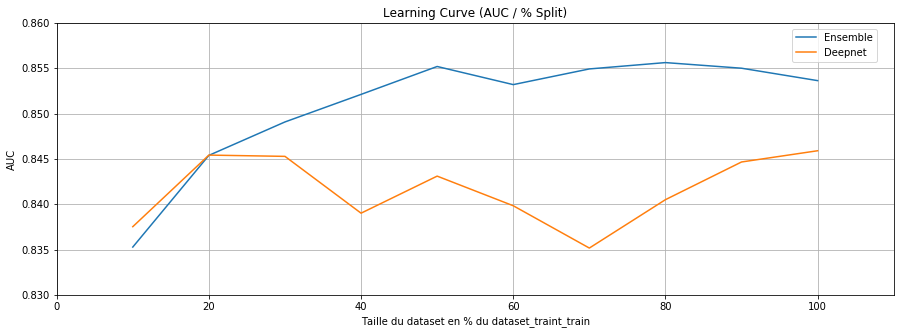

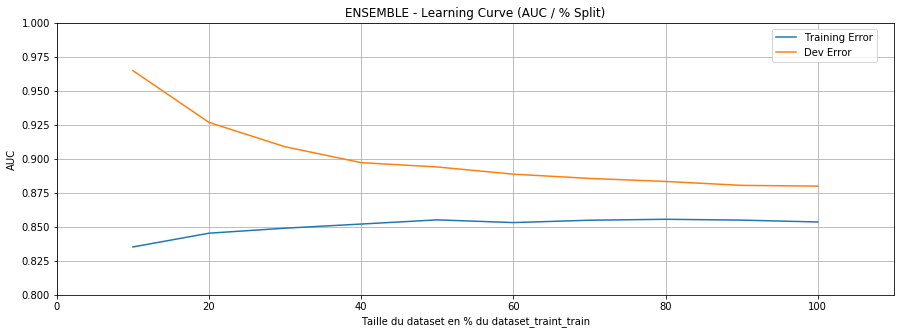

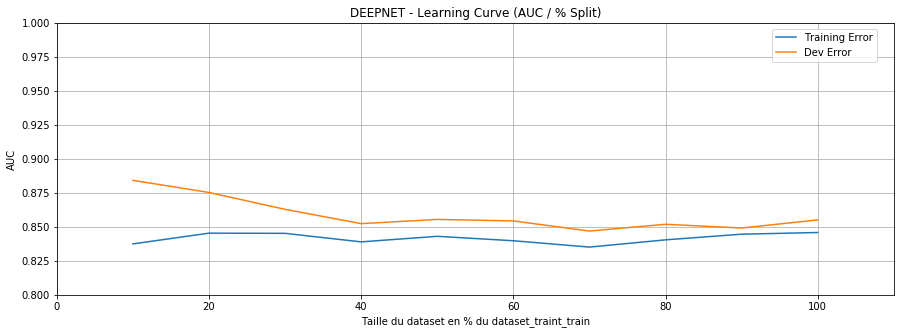

In [51]:
# On ouvre le fichier contenant les datas du projet, notamment les AUC
with open(jar_filename, 'rb') as file:
    project_data = load(file)

# On initialise les listes graph_x et graph_y
graph_x = []
graph_y_valset_ensemble = []
graph_y_valset_deepnet = []
graph_y_trainset_ensemble = []
graph_y_trainset_deepnet = []

# On complète les listes depuis les datas du projet
i = 10
for auc in project_data.values():
    graph_x.append(i)
    graph_y_valset_ensemble.append(auc['evaluations']['val_set']['Ensemble']['auc'])
    graph_y_valset_deepnet.append(auc['evaluations']['val_set']['Deepnet']['auc'])
    graph_y_trainset_ensemble.append(auc['evaluations']['train_set']['Ensemble']['auc'])
    graph_y_trainset_deepnet.append(auc['evaluations']['train_set']['Deepnet']['auc'])
    i += 10


# On génère le graphique Learning Curve (AUC / % Split)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(graph_x, graph_y_valset_ensemble, label='Ensemble')
ax.plot(graph_x, graph_y_valset_deepnet, label='Deepnet')
ax.set(xlim=(0, 110), ylim=(0.83, 0.86), xlabel='Taille du dataset en % du dataset_traint_train', ylabel='AUC',  title='Learning Curve (AUC / % Split)')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='best', borderaxespad=0.)
ax.grid()
plt.show()

# On génère le graphique ENSEMBLE - Learning Curve (AUC / % Split)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(graph_x, graph_y_valset_ensemble, label='Training Error')
ax.plot(graph_x, graph_y_trainset_ensemble, label='Dev Error')
ax.set(xlim=(0, 110), ylim=(0.8, 1), xlabel='Taille du dataset en % du dataset_traint_train', ylabel='AUC',  title='ENSEMBLE - Learning Curve (AUC / % Split)')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='best', borderaxespad=0.)
ax.grid()
plt.show()

# On génère le graphique DEEPNET - Learning Curve (AUC / % Split)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(graph_x, graph_y_valset_deepnet, label='Training Error')
ax.plot(graph_x, graph_y_trainset_deepnet, label='Dev Error')
ax.set(xlim=(0, 110), ylim=(0.8, 1), xlabel='Taille du dataset en % du dataset_traint_train', ylabel='AUC',  title='DEEPNET - Learning Curve (AUC / % Split)')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='best', borderaxespad=0.)
ax.grid()
plt.show()